### Resumo

In [1]:
#Importação das bibliotecas necessárias

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from pandas.core.dtypes.api import is_numeric_dtype

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score, accuracy_score, silhouette_samples

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif

# Modelos Classificadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Carga dos dados
data1 = pd.read_csv('CAR-recursos-naturais-municipios.csv')
data2 = pd.read_csv('IDH-cidades.csv')
#Troquei os valores NaN por zero, verificar o impacto disso
data3 = pd.read_csv('IBGE-municipios.csv')


In [89]:
#Merge dos datasets importados
data = pd.merge(data1, data2, how='inner', on="Nome do Município")
data = pd.merge(data, data3, how='inner', on="Nome do Município")

data.head()

,Nome do Município,APP,Altitude Superior 1800,Consolidada,Declividade Maior 45,Imoveis,Pousio,Topo de Morro,Banhado,Borda Chapada,...,Total receitas realizadas(2017),Total receitas empenhadas(2017),Mortalidade infantil(2019),Internacoes por diarreia(2016),Estabelecimentos SUS(2009),Area territorial(2021),Esgotamento adequado(2010),Arborização vias publicas(2010),Urbanizacao vias publicas(2010),Bioma
0,Belo Vale,4489,0,844,3,1055,47,2,3,0,...,45642.25,32123.19,10.75,0.8,5,365.923,48.2,67.7,27.8,Mata Atlântica
1,Betim,2664,0,446,2,741,9,1,3,0,...,1775733.39,1363402.09,13.06,0.1,73,343.884,86.0,74.3,33.4,Cerrado e Mata Atlântica
2,Bonfim,6133,0,1749,1,2064,41,1,0,0,...,19095.87,19887.69,0.00,0.0,4,301.865,38.5,40.9,9.4,Mata Atlântica
3,Brumadinho,7419,0,787,15,1177,44,8,1,0,...,175543.55,165401.05,17.20,0.3,27,639.434,65.4,59.3,19.5,Mata Atlântica
4,Cachoeira da Prata,330,0,67,0,61,1,0,1,0,...,15260.12,12455.95,25.00,0.0,2,61.381,92.6,28.6,7.2,Cerrado


In [5]:
#Visualização do tipo dos dados
data.dtypes

Nome do Município                                               object
APP                                                              int64
Altitude Superior 1800                                           int64
Consolidada                                                      int64
Declividade Maior 45                                             int64
Imoveis                                                          int64
Pousio                                                           int64
Topo de Morro                                                    int64
Banhado                                                          int64
Borda Chapada                                                    int64
Hidrografia                                                      int64
Manguezal                                                        int64
Nascentes                                                        int64
Reserva Legal                                                    int64
Restin

In [6]:
#Remoção dos dados categóricos

df = data.select_dtypes(include=np.number)

In [7]:
#Visualização dos valores extremos

print(df.max())
print(df.min())

APP                                                              15142.000
Altitude Superior 1800                                               1.000
Consolidada                                                       2235.000
Declividade Maior 45                                                17.000
Imoveis                                                           2064.000
Pousio                                                             150.000
Topo de Morro                                                       27.000
Banhado                                                             60.000
Borda Chapada                                                        5.000
Hidrografia                                                       2069.000
Manguezal                                                            1.000
Nascentes                                                         1544.000
Reserva Legal                                                     2540.000
Restinga                 

In [8]:
#Como a amplitude dos valores é alta, é necessário normalizar os dados
df_norm = minmax_scale(df)

In [9]:
#Método Elbow (ou Método do "Joelho"): Encontrando um valor ideal para o número de clusters
inicio = 2
fim = 20
inercia = []

for i in range(inicio, fim):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_norm)
    inercia.append(kmeans.inertia_)

#Cálculo da maior queda do "joelho"
diferencas = []
for j in range(2,len(inercia)):
    if j+1 != len(inercia):
        t = []
        m = inercia[j] - inercia[j+1]
        t.append(j+1)
        t.append(m)
        diferencas.append(t)

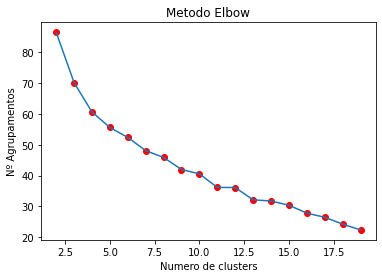

In [10]:
#Gráfico da variância em relação ao número de clusters
#Lembrando: maior a variância, maior a dispersão dos dados
plt.plot(range(inicio, fim), inercia)
plt.scatter(range(inicio, fim), inercia, c='red')
plt.title('Metodo Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Nº Agrupamentos')
plt.show()

In [11]:
#O valor de K escolhido será aquele que possui a maior diferença associado, representando assim a maior queda
print(diferencas)

[[3, 5.0152414528414155], [4, 3.2425955413565717], [5, 4.27228025956223], [6, 2.207759166538416], [7, 3.922300385502261], [8, 1.4002181508857632], [9, 4.395899527991894], [10, 0.039603288981147955], [11, 3.9886081289943505], [12, 0.38280090007534184], [13, 1.3769157616308796], [14, 2.552927517803319], [15, 1.3505592780972222], [16, 2.2150652060768508], [17, 1.8817041610290985]]


In [12]:
#Ordena o vetor de forma decrescente com base na diferença calculada
valorK = sorted(diferencas, key=lambda diferenca: diferenca[1], reverse=True)
#maior valor da diferenca
print(valorK[0])

[3, 5.0152414528414155]


In [23]:
#TESTE: verifica que os valores de K variam conforme a execução
#Executa o "Método Elbow" várias vezes a fim de se obter o valor de K que mais se repete

#IMPORTANTE: Algo inovador da minha metodologia

#Necessário definir sempre um mesmo valor de K
import statistics as st

def define_K():
    quantidade = 10
    valores = []
    
    for vez in range(quantidade):
        inicio = 2
        fim = 10
        inercia = []

        for i in range(inicio, fim):
            kmeans = KMeans(n_clusters = i)
            kmeans.fit(df_norm)
            inercia.append(kmeans.inertia_)

        #Cálculo da maior queda do "joelho"
        diferencas = []
        for j in range(2,len(inercia)):
            if j+1 != len(inercia):
                t = []
                m = inercia[j] - inercia[j+1]
                t.append(j+1)
                t.append(m)
                diferencas.append(t)
        valorK = sorted(diferencas, key=lambda diferenca: diferenca[1], reverse=True)
        valores.append((valorK[0][0]))
    #return sum(valores)/quantidade
    return valores

print(define_K())
print(st.mode(define_K()))

[3, 5, 3, 3, 3, 3, 3, 3, 3, 3]
3


In [24]:
#TESTE
#Reduzindo a dimensão - atributos com correlação alta

limiar_corr = 0.85
corr = np.abs(data.corr())
correlacoes = corr.to_numpy()

data = data.select_dtypes(include=np.number)

numericas = data.columns.to_list()

numericas_rem = set([])
for i in range(0, len(numericas)-1):
  for j in range(i+1, len(numericas)):
    c = correlacoes[i,j]
    if np.round(c,1) >= limiar_corr:
      # Houve um "empate técnico" de correlação
      vi = np.var(data[numericas[i]])
      vj = np.var(data[numericas[j]])
      if vi >= vj:
        removida = numericas[j]
      else:
        removida = numericas[i]
      numericas_rem = numericas_rem.union(set([removida]))

numericas_sel = set(numericas).difference(numericas_rem)

print(numericas_rem)
print(numericas_sel)

numericas_sel = list(numericas_sel)
numericas_rem = list(numericas_rem)

{'Vegetação Nativa', 'Imoveis', 'População estimada(2021)', 'Estabelecimentos SUS(2009)', 'Servidão Administrativa', 'Populacao ocupada(2019)', 'Matriculas ensino fundamental(2020)', 'Matriculas ensino medio(2020)', 'Total receitas empenhadas(2017)', 'Docentes ensino fundamental(2020)', 'Reserva Legal', 'Manguezal', 'Consolidada', 'Salario medio mensal(2019)', 'População censo(2010)', 'Nascentes', 'Densidade demografica(2010)', 'Docentes ensino medio(2020)', 'IDHM Renda 2010', 'Numeros estabelecimentos ensino fundamental(2010)', 'Numeros estabelecimentos ensino medio(2020)', 'IDH 2010', 'Hidrografia', 'Pessoal ocupado(2019)', 'IDHM(2010)'}
{'Urbanizacao vias publicas(2010)', 'Vereda', 'Percentual receitas fontes externas(2015)', 'Internacoes por diarreia(2016)', 'Pousio', 'IDEB anos finais ensino fundamental(2019).1', 'Restinga', 'IDEB anos finais ensino fundamental(2019)', 'Borda Chapada', 'PIB per capita(2019)', 'Banhado', 'Area territorial(2021)', 'Arborização vias publicas(2010)', 

In [54]:
#Silhouete Score

In [25]:
#PCA = Reduzindo a dimensionalidade dos dados
#OBS.: Reduzindo a dimensão, é perdido a informação dos valores dos dados

pca = PCA(n_components = 2)
pcaTransformacao = pca.fit_transform(df_norm)

In [46]:
#Algoritmo K-Means

#Calculando os agrupamentos dos dados na dimensão K
K = st.mode(define_K())

#IMPORTANTE: Explicar a escolha de cada valor aqui do parâmetro
kmeans = KMeans(n_clusters = K, init='k-means++', tol=0.0001, verbose=0, random_state = 0, max_iter = 100, copy_x=True, n_init=10, algorithm='elkan')

cluster = kmeans.fit_predict(pcaTransformacao)
#cluster = kmeans.fit_predict(df_norm)

#Centroides de cada um dos clusters gerados
centroids = kmeans.cluster_centers_

#print(cluster)
print(centroids)

[[ 2.21968395  0.48861674]
 [ 0.07186853 -0.5771875 ]
 [-0.37781945  0.53679374]]


In [47]:
#Algoritmo KMeans sem uso do PCA
#Importância: Pegar os valores dos dados dos centroides dos agrupomentos

df = df.select_dtypes(include=np.number)
min_max = MinMaxScaler()
df_norm_2 = min_max.fit_transform(df)

K = st.mode(define_K())
kmeans = KMeans(n_clusters = K, init='k-means++', tol=0.0001, verbose=0, random_state = 0, max_iter = 100, copy_x=True, n_init=10, algorithm='elkan')
cluster = kmeans.fit_predict(df_norm_2)
centroide_dado_bruto = kmeans.cluster_centers_

valor_referencia_centroide = min_max.inverse_transform(centroide_dado_bruto)

#print(valor_referencia_centroide)
print(centroide_dado_bruto)

[[9.42173754e-02 6.93889390e-18 1.08105298e-01 1.12299465e-01
  1.46711751e-01 6.66666667e-02 5.38720539e-02 5.37878788e-02
  1.81818182e-02 1.34353362e-01 6.93889390e-18 7.17407998e-02
  1.13263189e-01 1.56739812e-03 6.90587548e-02 1.39230139e-02
  1.03128055e-01 1.08071348e-04 5.54347826e-01 4.76682409e-01
  5.51948052e-01 6.10236220e-01 3.31598500e-02 3.11433161e-02
  6.42406048e-02 1.26099707e-01 1.91427861e-02 1.22703412e-01
  4.61204401e-01 8.42635213e-01 8.58032379e-01 7.53968254e-01
  4.05609336e-02 4.01636214e-02 4.25088610e-02 4.04402188e-02
  5.40259740e-02 2.93706294e-02 4.37588291e-02 7.61208297e-01
  5.26599327e-01 3.24236831e-02 3.07173481e-02 1.49154290e-01
  1.38636364e-01 3.89994621e-02 5.06823693e-02 6.02079304e-01
  7.14320890e-01 3.64026867e-01]
 [3.46706989e-01 0.00000000e+00 4.51865406e-01 3.52941176e-01
  5.78742997e-01 1.94074074e-01 2.18106996e-01 1.35185185e-01
  0.00000000e+00 4.45864046e-01 1.11111111e-01 2.59403653e-01
  4.47648289e-01 1.13026820e-01 2.397

In [67]:
#Criando dataframe com os valores dos centroides para visualização dos valores 

#IMPORTANTE: Algo inovador da minha metodologia

atributos = df.columns
d = pd.DataFrame(np.round(centroide_dado_bruto, 5), columns=atributos)
display(d)


,APP,Altitude Superior 1800,Consolidada,Declividade Maior 45,Imoveis,Pousio,Topo de Morro,Banhado,Borda Chapada,Hidrografia,...,IDHM(2010),Total receitas realizadas(2017),Total receitas empenhadas(2017),Mortalidade infantil(2019),Internacoes por diarreia(2016),Estabelecimentos SUS(2009),Area territorial(2021),Esgotamento adequado(2010),Arborização vias publicas(2010),Urbanizacao vias publicas(2010)
0,0.09422,0.00000,0.10811,0.11230,0.14671,0.06667,0.05387,0.05379,0.01818,0.13435,...,0.52660,0.03242,0.03072,0.14915,0.13864,0.03900,0.05068,0.60208,0.71432,0.36403
1,0.34671,0.00000,0.45187,0.35294,0.57874,0.19407,0.21811,0.13519,0.00000,0.44586,...,0.88560,0.33867,0.32454,0.16669,0.12222,0.35766,0.25069,0.89421,0.58168,0.48377
2,0.38546,0.05882,0.49682,0.20761,0.60683,0.30078,0.11765,0.10392,0.10588,0.51626,...,0.22222,0.01369,0.01257,0.17555,0.22059,0.03307,0.15875,0.42960,0.57880,0.35233


<AxesSubplot:>

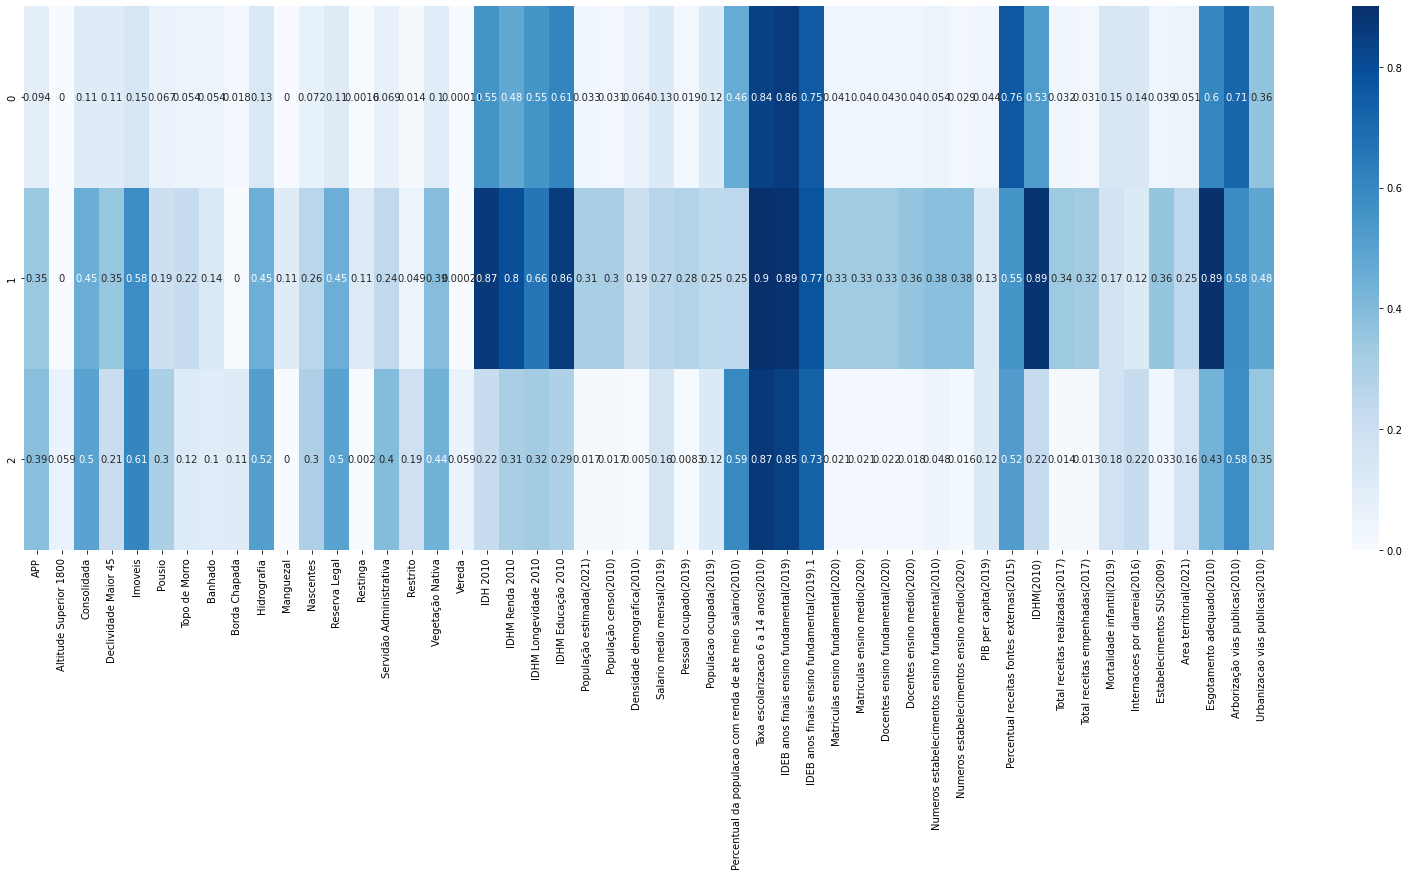

In [86]:
#Heatmap do dataframe dos centroides

#IMPORTANTE: Algo inovador da minha metodologia

fig, ax = plt.subplots(figsize=(28,10))  
#import seaborn as sns
sns.heatmap(d, annot=True, cmap="Blues")

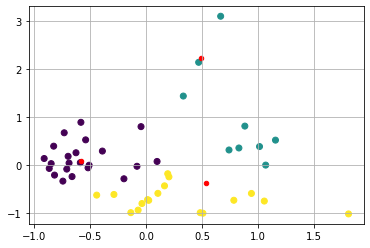

In [87]:
#Plotagem bidimensional dos agrupamentos formados

plt.scatter(pcaTransformacao[:,1], pcaTransformacao[:,0], c=cluster)
plt.grid()
plt.scatter(centroids[:,1], centroids[:,0], s=20, c='red')
plt.show()

In [92]:
#Visualização das cidades em cada um dos agrupamentos formados

#IMPORTANTE: Algo inovador da minha metodologia

#REFATORAR ESSE CÓDIGO AQUI

c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []

#Valores PCA por cluster
c0_pca = []
c1_pca = []
c2_pca = []
c3_pca = []
c4_pca = []
c5_pca = []
c6_pca = []

indice = 0
cidades = []

for i in cluster:
    if i == 0:
        c0.append(data['Nome do Município'][indice])
        c0_pca.append(pcaTransformacao[indice])
    elif i == 1:
        c1.append(data['Nome do Município'][indice])
        c1_pca.append(pcaTransformacao[indice])
    elif i == 2:
        c2.append(data['Nome do Município'][indice])
        c2_pca.append(pcaTransformacao[indice])
    elif i == 3:
        c3.append(data['Nome do Município'][indice])
        c3_pca.append(pcaTransformacao[indice])
    elif i == 4:
        c4.append(data['Nome do Município'][indice])
        c4_pca.append(pcaTransformacao[indice])
    elif i == 5:
        c5.append(data['Nome do Município'][indice])
        c5_pca.append(pcaTransformacao[indice])
    else:
        c6.append(data['Nome do Município'][indice])
        c6_pca.append(pcaTransformacao[indice])
    indice+=1

if len(c0) != 0:
    cidades.append(c0)
if len(c1) != 0:
    cidades.append(c1)
if len(c2) != 0:
    cidades.append(c2)
if len(c3) != 0:
    cidades.append(c3)
if len(c4) != 0:
    cidades.append(c4)
if len(c5) != 0:
    cidades.append(c5)
if len(c6) != 0:
    cidades.append(c6)

display(cidades)

[['Cachoeira da Prata',
  'Caetanópolis',
  'Congonhas',
  'Cristiano Otoni',
  'Florestal',
  'Fortuna de Minas',
  'Ibirité',
  'Igarapé',
  'Inhaúma',
  'Juatuba',
  'Maravilhas',
  'Mario Campos',
  'Mateus Lemes',
  'Ouro Branco',
  'Papagaios',
  'Paraopeba',
  'Pequi',
  'Queluzito',
  'São Brás do Suaçuí',
  'São Joaquim de Bicas',
  'São José da Varginha',
  'Sarzedo'],
 ['Betim',
  'Brumadinho',
  'Conselheiro Lafaiete',
  'Contagem',
  'Curvelo',
  'Itaúna',
  'Ouro Preto',
  'Pará de Minas',
  'Sete Lagoas'],
 ['Belo Vale',
  'Bonfim',
  'Casa Grande',
  'Crucilândia',
  'Desterro de Entre Rios',
  'Entre Rios de Minas',
  'Esmeraldas',
  'Felixlândia',
  'Itatiaiuçu',
  'Itaverava',
  'Jeceaba',
  'Lagoa Dourada',
  'Moeda',
  'Piedade dos Gerais',
  'Pompéu',
  'Resende Costa',
  'Rio Manso']]

In [106]:
#Função que retorna a distância e o índice da cidade mais próxima do centroide de um agrupamento

import math

def ponto_mais_proximo_centroide(agrupamento_pca, centroide):
    distancia_indice = []
    indice = 0
    for cidade in agrupamento_pca:
        val = []
        x = cidade[0]-centroide[0]
        y = cidade[1]-centroide[1]
        delta = abs(pow(x,2) - pow(y,2))
        val.append(math.sqrt(delta))
        val.append(indice)
        distancia_indice.append(val)
        indice+=1
    
    return min(distancia_indice)


c0_indice = ponto_mais_proximo_centroide(c0_pca, centroids[0])
c1_indice = ponto_mais_proximo_centroide(c1_pca, centroids[1])
c2_indice = ponto_mais_proximo_centroide(c2_pca, centroids[2])

print(c0[c0_indice[1]])
print(c1[c1_indice[1]])
print(c2[c2_indice[1]])

cidades_centroides = [c0[c0_indice[1]], c1[c1_indice[1]], c2[c2_indice[1]]]

#Array com os valores PCA de cada cluster

Ibirité
Sete Lagoas
Itaverava


In [107]:
#Dados das cidades mais próximas do centroide de cada agrupamento

for cidade in cidades_centroides:
    display(data.iloc[data[data['Nome do Município'] == cidade].index[0]])


Nome do Município                                                     Ibirité
APP                                                                       262
Altitude Superior 1800                                                      0
Consolidada                                                                49
Declividade Maior 45                                                        0
Imoveis                                                                    65
Pousio                                                                      2
Topo de Morro                                                               0
Banhado                                                                     0
Borda Chapada                                                               0
Hidrografia                                                                34
Manguezal                                                                   0
Nascentes                                                       

Nome do Município                                              Sete Lagoas
APP                                                                   2583
Altitude Superior 1800                                                   0
Consolidada                                                            694
Declividade Maior 45                                                     2
Imoveis                                                                736
Pousio                                                                  24
Topo de Morro                                                            3
Banhado                                                                  1
Borda Chapada                                                            0
Hidrografia                                                            557
Manguezal                                                                0
Nascentes                                                               76
Reserva Legal            

Nome do Município                                                   Itaverava
APP                                                                      4548
Altitude Superior 1800                                                      0
Consolidada                                                               919
Declividade Maior 45                                                        0
Imoveis                                                                   878
Pousio                                                                     20
Topo de Morro                                                               0
Banhado                                                                     8
Borda Chapada                                                               0
Hidrografia                                                               807
Manguezal                                                                   0
Nascentes                                                       

In [20]:
#REFERÊNCIA

K = valorK[0][0]

pca = PCA(n_components = 2)
pcaTransformacao = pca.fit_transform(df_norm)

kmeans = KMeans(n_clusters = K, random_state = 0, max_iter = 100)
cluster = kmeans.fit_predict(pcaTransformacao)

centroids = kmeans.cluster_centers_

c0 = []
c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
indice = 0

for i in cluster:
    
    if i == 0:
        c0.append(data['Nome do Município'][indice])
    elif i == 1:
        c1.append(data['Nome do Município'][indice])
    elif i == 2:
        c2.append(data['Nome do Município'][indice])
    elif i == 3:
        c2.append(data['Nome do Município'][indice])
    elif i == 4:
        c2.append(data['Nome do Município'][indice])
    elif i == 5:
        c2.append(data['Nome do Município'][indice])
    else:
        c6.append(data['Nome do Município'][indice])
    indice+=1

print(c0)
print(c1)
print(c2)
print(c3)
print(c4)
print(c5)
print(c6)

'''
plt.scatter(pcaTransformacao[:,1], pcaTransformacao[:,0], c=cluster)
plt.grid()
plt.scatter(centroids[:,1], centroids[:,0], s=10, c='red') 

plt.show()
'''


['Brumadinho', 'Casa Grande', 'Felixlândia', 'Mateus Lemes', 'Ouro Preto', 'Queluzito']
['Belo Vale', 'Conselheiro Lafaiete', 'Crucilândia', 'Itatiaiuçu', 'Itaverava', 'Jeceaba', 'Moeda', 'Piedade dos Gerais', 'Pompéu', 'Rio Manso', 'Sete Lagoas']
['Betim', 'Bonfim', 'Cachoeira da Prata', 'Caetanópolis', 'Congonhas', 'Contagem', 'Cristiano Otoni', 'Curvelo', 'Desterro de Entre Rios', 'Entre Rios de Minas', 'Esmeraldas', 'Florestal', 'Fortuna de Minas', 'Ibirité', 'Igarapé', 'Inhaúma', 'Itaúna', 'Juatuba', 'Lagoa Dourada', 'Maravilhas', 'Mario Campos', 'Ouro Branco', 'Papagaios', 'Pará de Minas', 'Paraopeba', 'Pequi', 'Resende Costa', 'São Brás do Suaçuí', 'São Joaquim de Bicas', 'São José da Varginha', 'Sarzedo']
[]
[]
[]
[]


"\nplt.scatter(pcaTransformacao[:,1], pcaTransformacao[:,0], c=cluster)\nplt.grid()\nplt.scatter(centroids[:,1], centroids[:,0], s=10, c='red') \n\nplt.show()\n"